# Multivariate statistics (decoding / MVPA) on MEG/EEG

Author : Alexandre Gramfort

See more info on decoding on this page: https://martinos.org/mne/stable/auto_tutorials/plot_sensors_decoding.html

In [1]:
# add plot inline in the page
%matplotlib inline
import matplotlib.pyplot as plt

First, load the mne package:

In [2]:
import mne

We set the log-level to 'WARNING' so the output is less verbose

In [3]:
mne.set_log_level('WARNING')

## Access raw data

Now we import the sample dataset. If you don't already have it, it will be downloaded automatically (but be patient approx. 2GB)

In [5]:
from mne.datasets import sample
data_path = sample.data_path()

#data_path = '/Users/alex/mne_data/MNE-sample-data'

raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec), ~123.3 MB, data loaded>

High pass the data above 1Hz

In [6]:
raw.filter(1, None)

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec), ~123.3 MB, data loaded>

In [7]:
print(raw.info)

<Info | 19 non-empty fields
    bads : list | MEG 2443, EEG 053
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (GRAD: 204, MAG: 102, STIM: 9, EEG: 60, EOG: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
    events : list | 0 items
    file_id : dict | 4 items
    highpass : float | 1.0 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0 Hz
    meas_date : tuple | 2002-12-03 19:01:10 GMT
    meas_id : dict | 4 items
    nchan : int | 376
    proc_history : list | 0 items
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : float | 150.15374755859375 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    gantry_angle : NoneType
    hpi_subsystem :

## Define and read epochs

First extract events:

In [8]:
events = mne.find_events(raw, stim_channel='STI 014', verbose=True)

319 events found
Event IDs: [ 1  2  3  4  5 32]


Look at the design in a graphical way:

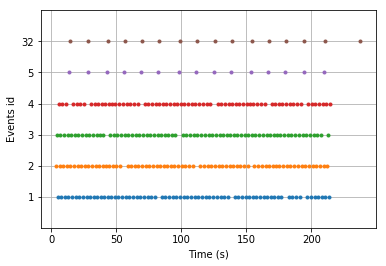

In [9]:
mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp);

## From raw to epochs

Define epochs parameters:

In [10]:
#event_id = dict(aud_l=1, aud_r=2)  # event trigger and conditions
event_id = {'aud_l': 1, 'aud_r': 2}  # event trigger and conditions
tmin = -0.1  # start of each epoch
tmax = 0.4  # end of each epoch
baseline = None  # no baseline as data were high passed

reject = dict(eeg=80e-6, eog=40e-6)

picks = mne.pick_types(raw.info, eeg=True, meg=True,
                       eog=True, stim=False, exclude='bads')

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline,
                    reject=reject, preload=True)  # with preload

print(epochs)

<Epochs  |   110 events (all good), -0.0998976 - 0.39959 sec, baseline off, ~26.9 MB, data loaded,
 'aud_l': 54
 'aud_r': 56>


Look at the ERF and contrast between left and rigth response

In [11]:
evoked_left = epochs['aud_l'].average()
evoked_right = epochs['aud_r'].average()
evoked_contrast = mne.combine_evoked([evoked_left, evoked_right],
                                     [0.5, -0.5])

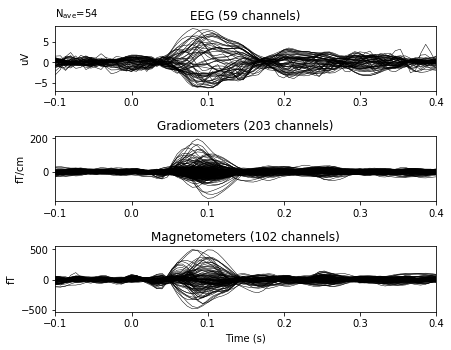

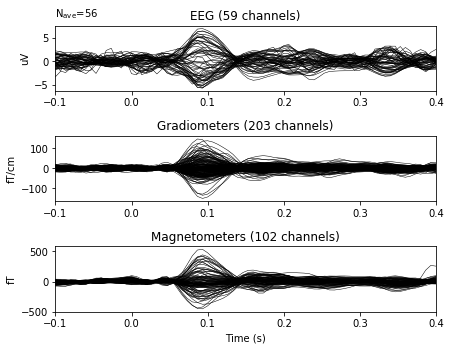

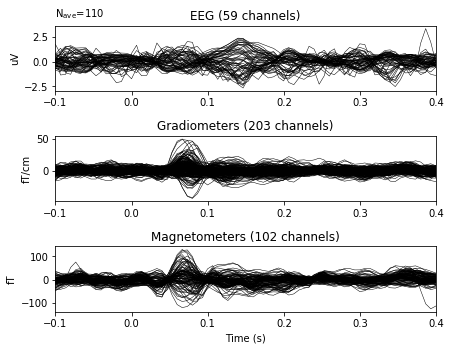

In [12]:
fig = evoked_left.plot()
fig = evoked_right.plot()
fig = evoked_contrast.plot()

Plot some topographies

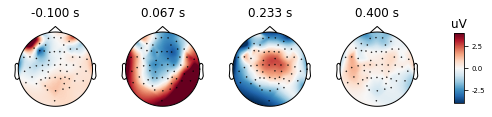

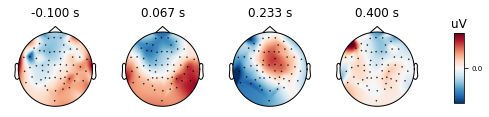

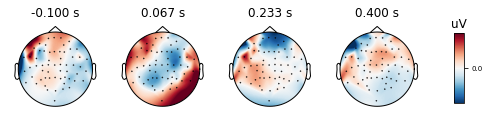

In [13]:
vmin, vmax = -4, 4
fig = evoked_left.plot_topomap(ch_type='eeg', contours=0, vmin=vmin, vmax=vmax)
fig = evoked_right.plot_topomap(ch_type='eeg', contours=0, vmin=vmin, vmax=vmax)
fig = evoked_contrast.plot_topomap(ch_type='eeg', contours=0, vmin=None, vmax=None)

## Now let's see if we can classify single trials

To have a chance at 50% accuracy equalize epoch count in each condition

In [14]:
epochs.equalize_event_counts(event_id)
print(epochs)

<Epochs  |   108 events (all good), -0.0998976 - 0.39959 sec, baseline off, ~26.5 MB, data loaded,
 'aud_l': 54
 'aud_r': 54>


A classifier takes as input an `x` and return `y` (0 or 1). Here x will be the data at one time point on all gradiometers (hence the term multivariate). We work with all sensors jointly and try to find a discriminative pattern between 2 conditions to predict the class.

For classification we will use the scikit-learn package (http://scikit-learn.org/) and MNE functions 

`
Reference:
Scikit-learn: Machine Learning in Python,
Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
`

In [15]:
import numpy as np
# make response vector
y = np.zeros(len(epochs.events), dtype=int)
y[epochs.events[:, 2] == 2] = 1

y.size

108

In [16]:
X = epochs.copy().pick_types(meg='grad').get_data()
X.shape

(108, 203, 76)

In [17]:
XX = X.reshape(108, -1)
XX.shape

(108, 15428)

In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e6, solver='liblinear')
cv = StratifiedKFold(n_splits=5, random_state=42)
scores = cross_val_score(logreg, XX[2:], y[2:], cv=cv, scoring='roc_auc')
print(scores)
print('Accuracy = %0.3f (std %.3f)' % (np.mean(scores), np.std(scores)))

[1.         0.88429752 0.88429752 0.87       0.83      ]
Accuracy = 0.894 (std 0.057)


(array([1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([0.83  , 0.8385, 0.847 , 0.8555, 0.864 , 0.8725, 0.881 , 0.8895,
        0.898 , 0.9065, 0.915 , 0.9235, 0.932 , 0.9405, 0.949 , 0.9575,
        0.966 , 0.9745, 0.983 , 0.9915, 1.    ]),
 <a list of 20 Patch objects>)

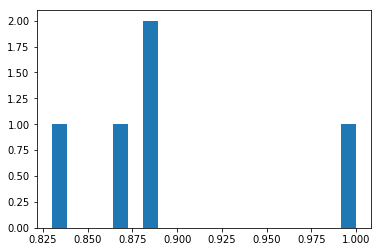

In [19]:
plt.hist(scores, bins=20)

Now we can do this more simply using the `mne.decoding` module

In [20]:
from sklearn.pipeline import make_pipeline
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore

epochs_decoding = epochs.copy().pick_types(meg='grad')

clf = make_pipeline(Scaler(epochs_decoding.info),
                    Vectorizer(),
                    logreg)

X = epochs_decoding.get_data()
y = epochs_decoding.events[:, 2]

scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))

Spatio-temporal: 84.1%


## Decoding over time

[............................................................] 100.00% Fitting SlidingEstimator |   
[............................................................] 100.00% Fitting SlidingEstimator |   
[............................................................] 100.00% Fitting SlidingEstimator |   
[............................................................] 100.00% Fitting SlidingEstimator |   
[............................................................] 100.00% Fitting SlidingEstimator |   


Text(0.5, 1.0, 'Sensor space decoding')

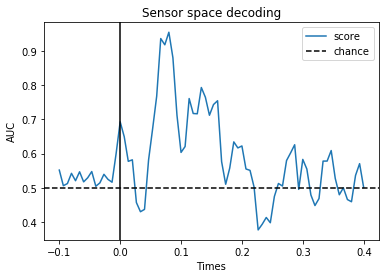

In [21]:
from sklearn.preprocessing import StandardScaler
from mne.decoding import SlidingEstimator

clf = make_pipeline(StandardScaler(), logreg)

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

For more details see: https://martinos.org/mne/stable/auto_tutorials/plot_sensors_decoding.html

and this book chapter:

Jean-Rémi King, Laura Gwilliams, Chris Holdgraf, Jona Sassenhagen, Alexandre Barachant, Denis Engemann, Eric Larson, Alexandre Gramfort. Encoding and Decoding Neuronal Dynamics: Methodological Framework to Uncover the Algorithms of Cognition. 2018. https://hal.archives-ouvertes.fr/hal-01848442/

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Do a time by time decoding o the spm face dataset to see if you can classify faces vs. scrambled faces.</li>
      <li>Do a generalization over time analysis as explained in the <a href="https://martinos.org/mne/dev/auto_tutorials/plot_sensors_decoding.html?highlight=generalizingestimator#temporal-generalization">documentation on decoding</a>.</li>
    </ul>
</div>

Example using the SPM face dataset: https://martinos.org/mne/dev/auto_examples/datasets/spm_faces_dataset.html